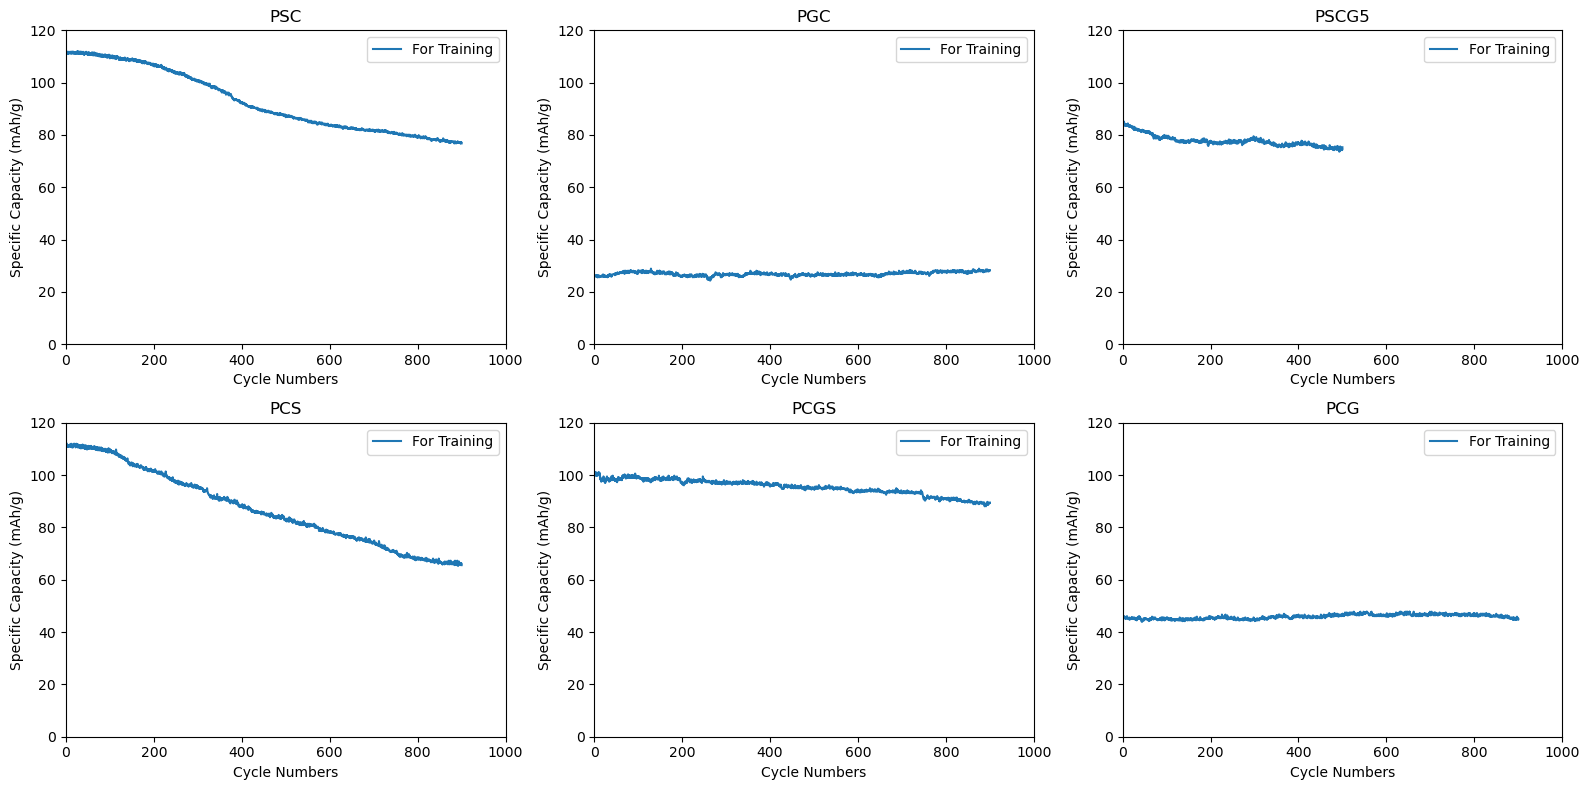

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.2956 - mae: 2.7524 - mse: 11.3599 - val_loss: 0.3543 - val_mae: 0.7185 - val_mse: 0.7481 - learning_rate: 0.0010
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2374 - mae: 0.5491 - mse: 0.5429 - val_loss: 0.0748 - val_mae: 0.3174 - val_mse: 0.1496 - learning_rate: 0.0010
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1992 - mae: 0.4989 - mse: 0.4397 - val_loss: 0.0372 - val_mae: 0.2133 - val_mse: 0.0743 - learning_rate: 0.0010
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1655 - mae: 0.4608 - mse: 0.3573 - val_loss: 0.0316 - val_mae: 0.2043 - val_mse: 0.0632 - learning_rate: 0.0010
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1390 - mae: 0.4199 - mse: 0.2952 - val_loss: 0.0189 - val_mae: 0.1615 - val_mse: 0.0378 - learning_rate: 0.0010
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1178 - mae: 0.3874 - mse: 0.2466 - val_loss: 0.0309 - val_mae

In [1]:
import time
start_time = time.time()

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import ReduceLROnPlateau


os.environ['PYTHONHASHSEED'] = '0'
random.seed(8)
np.random.seed(8)
tf.random.set_seed(8)

df = (
    pd.read_csv('train_valid_test.csv').drop_duplicates()
)

groups = {
    ('PGC', 900), ('PCG', 900), ('PCS', 900),
    ('PSC', 900), ('PCGS', 900), ('PSCG5', 500)
}
df_train = pd.concat(
    df[(df['name'] == name) & (df['cycle_n'] <= max_n)]
    for name, max_n in groups
)

plt.figure(figsize=(16, 8))
for i, (name, _) in enumerate(groups, 1):
    sub = df_train[df_train['name'] == name].sort_values('cycle_n')
    ax = plt.subplot(2, 3, i)
    ax.plot(sub['cycle_n'], sub['SepCap_Cycle'], label='For Training')
    ax.set(xlim=(0, 1000), ylim=(0, 120), title=name)
    ax.set_xlabel('Cycle Numbers')
    ax.set_ylabel('Specific Capacity (mAh/g)')
    ax.legend(ncol=2)
plt.tight_layout()
plt.show()

feat_cols = ['active_M', '2D_G', '1D_C', '0D_S', 'cycle_n']
target_col = 'SepCap_Cycle'

X = df_train[feat_cols].values
y = np.log1p(df_train[target_col].values)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)[..., None]
X_test  = scaler.transform(X_test)[..., None]

model = Sequential([
    Input(shape=(X_train.shape[1], 1)),
    Conv1D(32, 2, activation='relu', padding='same'),
    BatchNormalization(), MaxPooling1D(2),
    Conv1D(64, 2, activation='relu', padding='same'),
    BatchNormalization(), MaxPooling1D(2),
    Conv1D(128, 2, activation='relu', padding='same'),
    BatchNormalization(), MaxPooling1D(1),
    Flatten(),
    Dense(5, activation='linear'),
    Dropout(0.1),
    Dense(5, activation='linear'),
    Dense(1, activation='linear'),
])
model.compile(optimizer='adam', loss='huber', metrics=['mse', 'mae'])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5,
    patience=10, min_lr=1e-6, verbose=0.0001
)
history = model.fit(
    X_train, y_train,
    epochs=100, batch_size=32,
    validation_split=0.2,
    callbacks=[reduce_lr]
)

loss, mse, mae = model.evaluate(X_test, y_test)

y_pred = np.expm1(model.predict(X_test).flatten())
y_true = np.expm1(y_test)

end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step


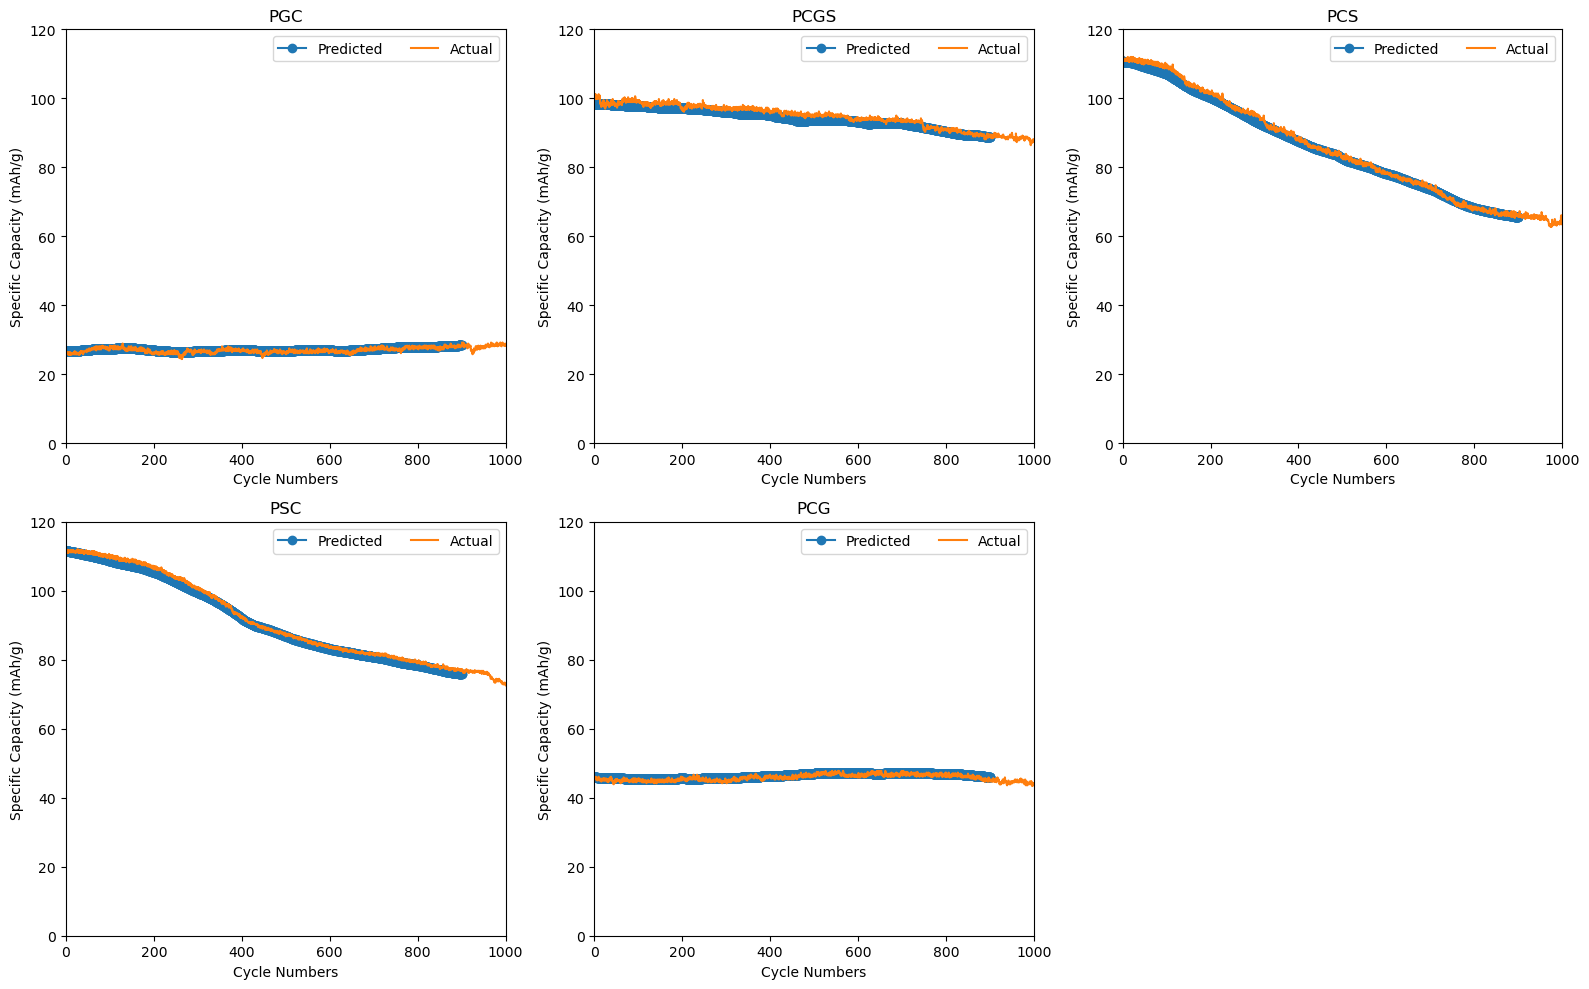

In [2]:
name_set = {'PGC', 'PCG', 'PCS', 'PSC', 'PCGS'}
mask = df['name'].isin(name_set) & (df['cycle_n'] <= 900)
df_valid_900 = df.loc[mask].drop_duplicates().copy()

X_val = scaler.transform(df_valid_900[feat_cols].values)[..., None]
df_valid_900['Predict_SepCap'] = np.expm1(model.predict(X_val).flatten())

plt.figure(figsize=(16, 10))
for i, nm in enumerate(name_set, start=1):
    sub_pred = df_valid_900[df_valid_900['name'] == nm]
    sub_act  = df[df['name'] == nm]
    ax = plt.subplot(2, 3, i)
    ax.plot(sub_pred['cycle_n'], sub_pred['Predict_SepCap'],
            marker='o', label='Predicted')
    ax.plot(sub_act ['cycle_n'], sub_act [target_col],
            label='Actual')
    ax.set(xlim=(0, 1000), ylim=(0, 120), title=nm,
           xlabel='Cycle Numbers', ylabel='Specific Capacity (mAh/g)')
    ax.legend(ncol=2)

plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


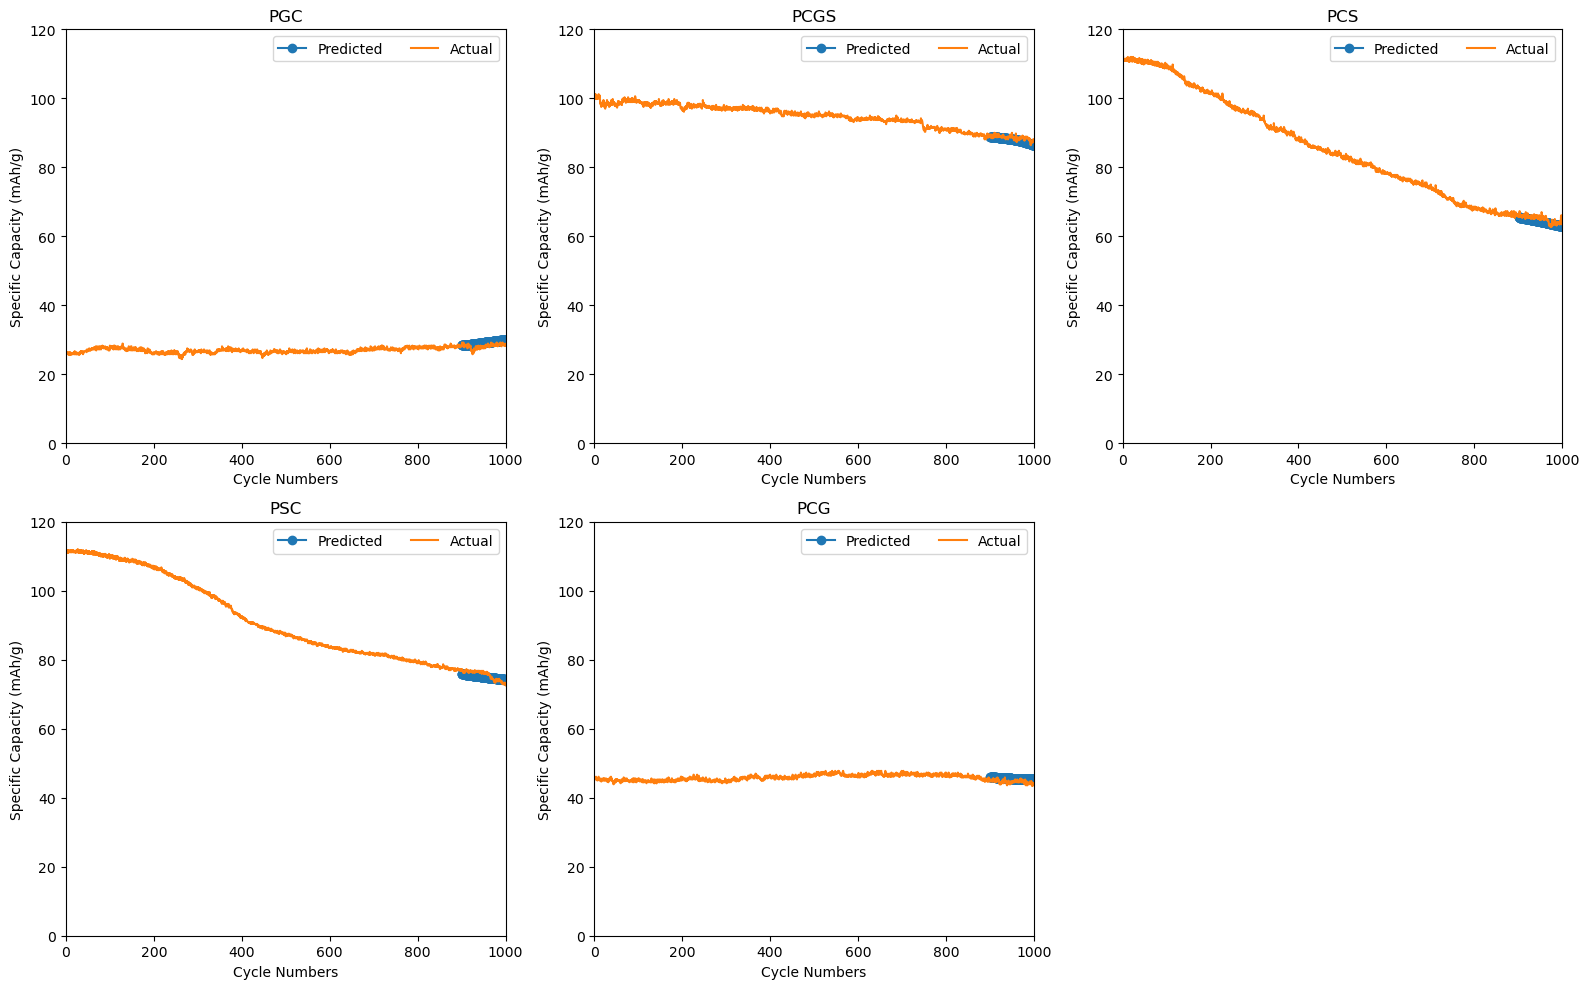

In [3]:
name_set = {'PGC', 'PCG', 'PCS', 'PSC', 'PCGS'}
mask = df['name'].isin(name_set) & (df['cycle_n'] > 900)
df_valid_900 = df.loc[mask].drop_duplicates().copy()

X_val = scaler.transform(df_valid_900[feat_cols].values)[..., None]
df_valid_900['Predict_SepCap'] = np.expm1(model.predict(X_val).flatten())

plt.figure(figsize=(16, 10))
for i, nm in enumerate(name_set, start=1):
    sub_pred = df_valid_900[df_valid_900['name'] == nm]
    sub_act  = df[df['name'] == nm]
    ax = plt.subplot(2, 3, i)
    ax.plot(sub_pred['cycle_n'], sub_pred['Predict_SepCap'],
            marker='o', label='Predicted')
    ax.plot(sub_act ['cycle_n'], sub_act [target_col],
            label='Actual')
    ax.set(xlim=(0, 1000), ylim=(0, 120), title=nm,
           xlabel='Cycle Numbers', ylabel='Specific Capacity (mAh/g)')
    ax.legend(ncol=2)

plt.tight_layout()
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


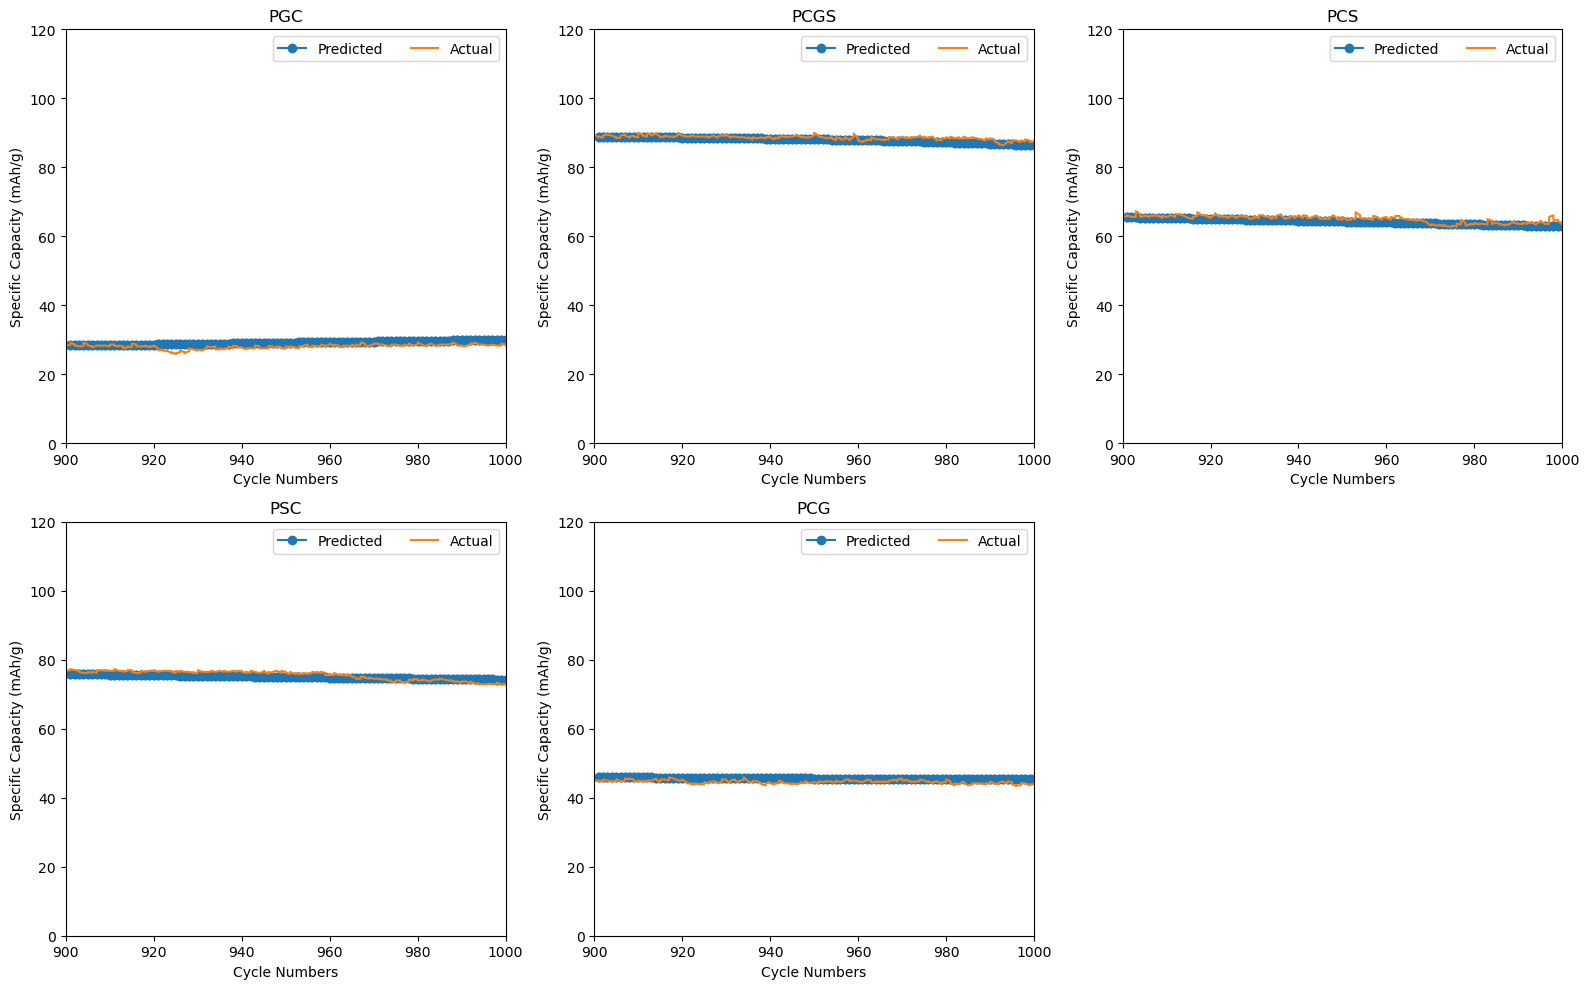

In [4]:
name_set = {'PGC', 'PCG', 'PCS', 'PSC', 'PCGS'}
mask = df['name'].isin(name_set) & (df['cycle_n'] > 900)
df_valid_900 = df.loc[mask].drop_duplicates().copy()

X_val = scaler.transform(df_valid_900[feat_cols].values)[..., None]
df_valid_900['Predict_SepCap'] = np.expm1(model.predict(X_val).flatten())

plt.figure(figsize=(16, 10))
for i, nm in enumerate(name_set, start=1):
    sub_pred = df_valid_900[df_valid_900['name'] == nm]
    sub_act  = df[df['name'] == nm]
    ax = plt.subplot(2, 3, i)
    ax.plot(sub_pred['cycle_n'], sub_pred['Predict_SepCap'],
            marker='o', label='Predicted')
    ax.plot(sub_act ['cycle_n'], sub_act [target_col],
            label='Actual')
    ax.set(xlim=(900, 1000), ylim=(0, 120), title=nm,
           xlabel='Cycle Numbers', ylabel='Specific Capacity (mAh/g)')
    ax.legend(ncol=2)

plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step


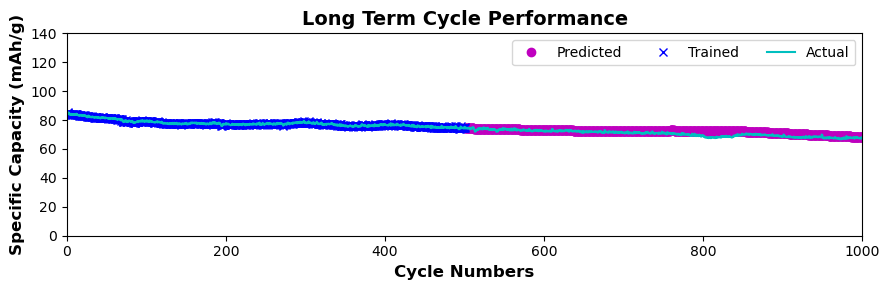

In [5]:
df_test2 = df[df['name']=='PSCG5'].drop_duplicates().copy()
X_test2  = scaler.transform(df_test2[feat_cols].values)[..., None]
df_test2['Predict_SepCap'] = np.expm1(model.predict(X_test2).flatten())

plt.figure(figsize=(9, 3))
mask = df_test2['cycle_n'] <= 500
plt.plot(df_test2.loc[~mask, 'cycle_n'], df_test2.loc[~mask, 'Predict_SepCap'], 'om', label='Predicted')
plt.plot(df_test2.loc[ mask, 'cycle_n'], df_test2.loc[ mask, 'SepCap_Cycle'],     'xb', label='Trained')
plt.plot(df_test2['cycle_n'],            df_test2['SepCap_Cycle'],            'c-', label='Actual')

plt.axis([0, 1000, 0, 140])
plt.title("Long Term Cycle Performance", fontsize=14, fontweight="bold")
plt.xlabel("Cycle Numbers",       fontsize=12, fontweight="bold")
plt.ylabel("Specific Capacity (mAh/g)", fontsize=12, fontweight="bold")
plt.legend(ncol=3)
plt.tight_layout()
plt.show()

In [6]:
import joblib 
import json

df.to_csv('raw_data.csv', index=False)
df_train.to_csv('df_train.csv', index=False)

idx = np.arange(len(df_train))
idx_tr, idx_te = train_test_split(idx, test_size=0.2, random_state=10)
np.save('idx_train.npy', idx_tr)
np.save('idx_test.npy',  idx_te)

df_train.iloc[idx_tr].to_csv('train_split_df.csv', index=False)
df_train.iloc[idx_te].to_csv('test_split_df.csv',  index=False)

np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy',  X_test)
np.save('y_test.npy',  y_test)

joblib.dump(scaler, 'scaler.joblib')
np.save('scaler_mean.npy', scaler.mean_)
np.save('scaler_scale.npy', scaler.scale_)

pd.DataFrame(history.history).to_csv('training_history.csv', index=False)

model.save_weights('model.weights.h5')

metrics = {
    'random_seed'  : 8,
    'test_loss_log': float(loss),
    'test_mse_log' : float(mse),
    'test_mae_log' : float(mae)
}
with open('metrics.json','w') as f:
    json.dump(metrics, f, indent=2)

np.save('y_pred.npy', y_pred)
np.save('y_true.npy', y_true)